In [1]:
import pandas as pd                 
import numpy as np                  
import re                           
import nltk                         
from nltk.corpus import stopwords   
import matplotlib.pyplot as plt

In [4]:
from numpy import array
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Activation, Dropout, Dense, Flatten, Conv1D, GlobalMaxPooling1D, Embedding
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer, text_to_word_sequence


Since the dataset is greater than 25mb it cannot be compressed or uploaded to github. So, I'm attaching the link to the dataset below.

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

In [5]:
np.random.seed(11)

In [7]:
movie_reviews = pd.read_csv("IMDB Dataset.csv")
# Checking for any null entries in dataset
print("\nIs the dataset having any null entries?")
print(movie_reviews.isnull().values.any())
# Printing dataset dimensions
print("\nDataset dimensions")
print(movie_reviews.shape)
# First 5 entries in datatset
print("\nFirst 5 entries in datatset")
print(movie_reviews.head())
# Number of positive and negative reviews in dataset
print("\nNumber of positive and negative reviews in dataset")
print(movie_reviews['sentiment'].value_counts())


Is the dataset having any null entries?
False

Dataset dimensions
(50000, 2)

First 5 entries in datatset
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Number of positive and negative reviews in dataset
sentiment
positive    25000
negative    25000
Name: count, dtype: int64


In [8]:
print("\nSAMPLE REVIEW")
print(movie_reviews['review'][4])


SAMPLE REVIEW
Petter Mattei's "Love in the Time of Money" is a visually stunning film to watch. Mr. Mattei offers us a vivid portrait about human relations. This is a movie that seems to be telling us what money, power and success do to people in the different situations we encounter. <br /><br />This being a variation on the Arthur Schnitzler's play about the same theme, the director transfers the action to the present time New York where all these different characters meet and connect. Each one is connected in one way, or another to the next person, but no one seems to know the previous point of contact. Stylishly, the film has a sophisticated luxurious look. We are taken to see how these people live and the world they live in their own habitat.<br /><br />The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits. A big city is not exactly the best place in which human relations find sincere fulfillment, as one discerns is 

In [9]:
def preprocess(sen):
    # Function to remove html tags is called
    sentence = remove_tags(sen)

    # Remove punctuations and numbers
    # '^' means NOT
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    return sentence



In [10]:
# Function to remove html tags
def remove_tags(text):
    return re.sub(r'<[^>]+>', '', text)

In [11]:
X = []
# Converting our dataset from type "dataframe" to type "list"
sentences = list(movie_reviews['review'])
for sen in sentences:
    X.append(preprocess(sen))

In [12]:
print("\nSAMPLE REVIEW AFTER PREPROCESSING")
print(X[4])


SAMPLE REVIEW AFTER PREPROCESSING
Petter Mattei Love in the Time of Money is visually stunning film to watch Mr Mattei offers us vivid portrait about human relations This is movie that seems to be telling us what money power and success do to people in the different situations we encounter This being variation on the Arthur Schnitzler play about the same theme the director transfers the action to the present time New York where all these different characters meet and connect Each one is connected in one way or another to the next person but no one seems to know the previous point of contact Stylishly the film has sophisticated luxurious look We are taken to see how these people live and the world they live in their own habitat The only thing one gets out of all these souls in the picture is the different stages of loneliness each one inhabits big city is not exactly the best place in which human relations find sincere fulfillment as one discerns is the case with most of the people we 

In [13]:
# One hot encoding of target feature
y = movie_reviews['sentiment']
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

In [14]:
#Splitting dataset into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=70)

In [15]:
tokenizer = Tokenizer(num_words=5000)
# Generate index for each string based on frequency (more frequent ; lesser the index value)
tokenizer.fit_on_texts(X_train)
print("\nNumber of unique words in training set") 
print(len(tokenizer.word_index))
# Substitute words with corresponding word index values
  # Only the words available in "fit_on_texts" will be considered. Others will be ignored  
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)


Number of unique words in training set
90134


In [16]:
# Adding '1' as index '0' is reserved in word_index
vocab_size = len(tokenizer.word_index) + 1
# Setting maximum length of each list(review) to be of length 100 words
maxlen = 100
# Making the train and test statements to be of size 100 by truncating or padding accordingly
X_train = pad_sequences(X_train, padding='post', maxlen=maxlen)
X_test = pad_sequences(X_test, padding='post', maxlen=maxlen)

In [19]:
import numpy as np

embeddings_dictionary = dict()
glove_file = open('glove.6B.100d.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    try:
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    except ValueError:
        # Skip any lines that do not contain valid floats
        print(f"Skipping line: {line}")
        continue

glove_file.close()


Skipping line: version https://git-lfs.github.com/spec/v1

Skipping line: oid sha256:95dde4dfd627ab26608d33e76d1195ec059734bd29089ea52cadb08d07c64544



In [20]:
# Creating embedding matrix
embedding_matrix = np.zeros((vocab_size, 100))
# Getting vector representation (from embedding dictionary) of each word in word_index
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    #If word is not available in GloVE embedding text file, that word will be skipped
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [21]:
# CONSTRUCTING SIMPLE DEEP NEURAL NETWORK

# Creating a sequential model
dnn_model = Sequential()
# Setting imput and output size to 100. Since we are using "GloVe - a predefined embedding", we set "trainable" to False
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
dnn_model.add(embedding_layer)
# Flattening the embedding the layer
    # layer of dimension (5, 3) becomes (1, 15)
dnn_model.add(Flatten())
# Adding Dense layer with one dimension output space
    # Dense is made at final layer - Fully connected layer
dnn_model.add(Dense(1, activation='sigmoid'))

C:\Users\hp\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [22]:
# Compiling the model
    #Optimizer used for faster convergence of model training
dnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])
# Printing the model summary
print("\nSIMPLE DEEP NEURAL NETWORK MODEL")
print(dnn_model.summary())


SIMPLE DEEP NEURAL NETWORK MODEL


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │       9,013,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,013,500 (34.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,013,500 (34.38 MB)

None


In [23]:
# Training our model
dnn_history = dnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
# Evaluating the model's accuracy
dnn_score = dnn_model.evaluate(X_test, y_test, verbose=1)
print("\nTEST SCORES OF MODEL")
print("Test loss:", dnn_score[0])
print("Test Accuracy:", dnn_score[1])

Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - acc: 0.5011 - loss: 46698.6289 - val_acc: 0.5008 - val_loss: 215326.0156
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4944 - loss: 46018.5625 - val_acc: 0.5008 - val_loss: 252988.3750
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4983 - loss: 49887.4141 - val_acc: 0.4993 - val_loss: 252988.3750
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.4983 - loss: 42453.0742 - val_acc: 0.4993 - val_loss: 252988.3750
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5019 - loss: 59309.1484 - val_acc: 0.5008 - val_loss: 252988.3750
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - acc: 0.5003 - loss: 44508.6523 - val_acc: 0.4993 - val_loss: 252988.3750
391/391 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - acc: 0.5081 - loss: 95543.2734

TEST SCORES OF MODEL
Test loss: 74802.015625
Test Accuracy: 0.5008800029754639


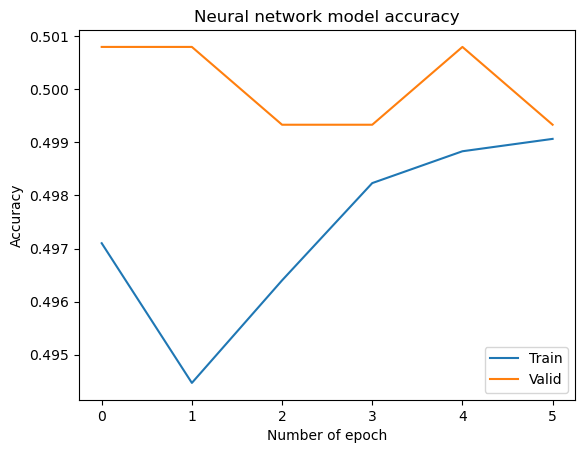

In [24]:
# Plotting graph for model built
    # Accuracy graph
plt.title('Neural network model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.plot(dnn_history.history['acc'], label = 'Train')
plt.plot(dnn_history.history['val_acc'], label = 'Valid')
plt.legend(loc='best')
plt.show()

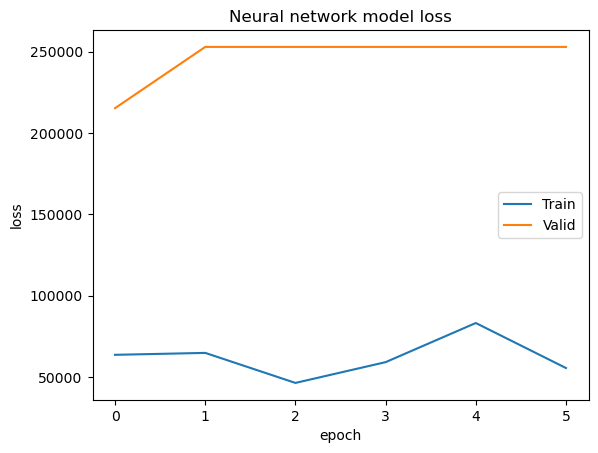

In [25]:
# Loss graph
plt.title('Neural network model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(dnn_history.history['loss'], label = 'Train')
plt.plot(dnn_history.history['val_loss'], label = 'Valid')
plt.legend(loc='best')
plt.show()

In [26]:
# CONSTRUCTING CONVOLUTION NEURAL NETWORK

# Creating a sequential model
cnn_model = Sequential()
# Setting imput and output size to 100. Since we are using "GloVe - a predefined embedding", we set "trainable" to False
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
cnn_model.add(embedding_layer)
# We use 1D CNN as 2D CNN is genrally used for images
    # 128 filters used - 128 different features can be detected
    # Window size is 5 - will consider 5 entries at a time
cnn_model.add(Conv1D(128, 5, activation='relu'))
# Pooling is done to avoid overfitting - also reduces the dimension of data
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1, activation='sigmoid'))

In [27]:
#Compiling the model
cnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])


In [28]:
# Printing the model summary
print("\nCONVOLUTIONAL NEURAL NETWORK 1D MODEL")
print(cnn_model.summary())


CONVOLUTIONAL NEURAL NETWORK 1D MODEL


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │       9,013,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d (Conv1D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d                 │ ?                           │     0 (unbuilt) │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,013,500 (34.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,013,500 (34.38 MB)

None


In [29]:
# Training our model
cnn_history = cnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
# Evaluating the model's accuracy
cnn_score = cnn_model.evaluate(X_test, y_test, verbose=1)
print("\nTEST SCORES OF MODEL")
print("Test loss:", cnn_score[0])
print("Test Accuracy:", cnn_score[1])

Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - acc: 0.4940 - loss: 386998.4062 - val_acc: 0.4999 - val_loss: 395093.0312
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - acc: 0.5038 - loss: 383638.1250 - val_acc: 0.5013 - val_loss: 2159410.0000
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - acc: 0.4978 - loss: 1118822.8750 - val_acc: 0.4999 - val_loss: 15983.1455
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - acc: 0.5004 - loss: 398864.1250 - val_acc: 0.4999 - val_loss: 187100.1406
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc: 0.4977 - loss: 250999.1406 - val_acc: 0.4999 - val_loss: 260996.3750
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - acc: 0.5043 - loss: 217611.3125 - val_acc: 0.5003 - val_loss: 189874.3906
391/391 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - acc: 0.4919 - loss: 92761.4297

TEST SCORES OF MODEL
Test loss: 99684.0859375
Test Accuracy: 0.4991999864578247


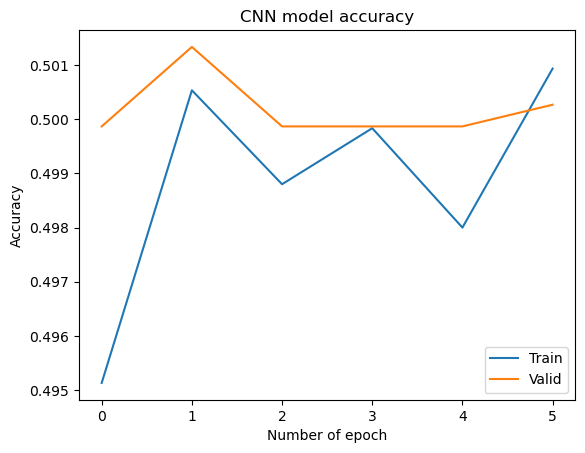

In [30]:
# Plotting graph for model built
    # Accuracy graph
plt.title('CNN model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.plot(cnn_history.history['acc'], label = 'Train')
plt.plot(cnn_history.history['val_acc'], label = 'Valid')
plt.legend(loc='best')
plt.show()

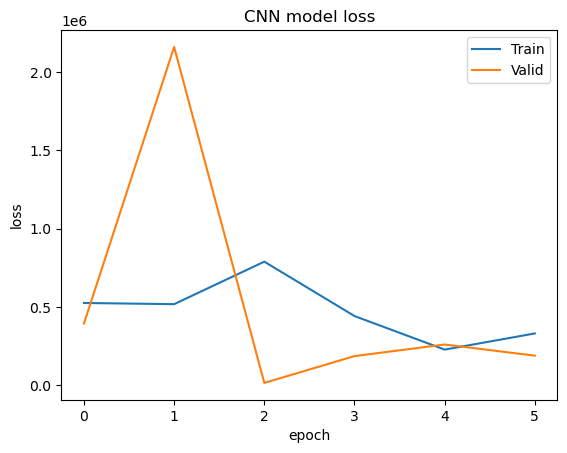

In [31]:
    # Loss graph
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(cnn_history.history['loss'], label = 'Train')
plt.plot(cnn_history.history['val_loss'], label = 'Valid')
plt.legend(loc='best')
plt.show()

In [32]:
# LSTM RECURRENT NEURAL NETWORK

# Creating a sequential model
rnn_model = Sequential()
# Setting imput and output size to 100. Since we are using "GloVe - a predefined embedding", we set "trainable" to False
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=maxlen , trainable=False)
rnn_model.add(embedding_layer)
# LSTM model is created with 128 neurons
rnn_model.add(LSTM(128))
rnn_model.add(Dense(1, activation='sigmoid'))

In [34]:
#Compiling the model
rnn_model.compile(optimizer='nadam', loss='binary_crossentropy', metrics=['acc'])

In [35]:
# Printing the model summary
print("\nLSTM RECURRENT NEURAL NETWORK MODEL")
print(rnn_model.summary())


LSTM RECURRENT NEURAL NETWORK MODEL


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       9,013,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 9,013,500 (34.38 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 9,013,500 (34.38 MB)

None


In [36]:
# Training our model
rnn_history = rnn_model.fit(X_train, y_train, batch_size=128, epochs=6, verbose=1, validation_split=0.2)
# Evaluating the model's accuracy
rnn_score = rnn_model.evaluate(X_test, y_test, verbose=1)
print("\nTEST SCORES OF MODEL")
print("Test loss:", rnn_score[0])
print("Test Accuracy:", rnn_score[1])

Epoch 1/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - acc: 0.5029 - loss: 0.6932 - val_acc: 0.4988 - val_loss: 0.6931
Epoch 2/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - acc: 0.4981 - loss: 0.6935 - val_acc: 0.5012 - val_loss: 0.6931
Epoch 3/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - acc: 0.5017 - loss: 0.6932 - val_acc: 0.5013 - val_loss: 0.6932
Epoch 4/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 173ms/step - acc: 0.4964 - loss: 0.6932 - val_acc: 0.4987 - val_loss: 0.6932
Epoch 5/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 171ms/step - acc: 0.4984 - loss: 0.6932 - val_acc: 0.5013 - val_loss: 0.6931
Epoch 6/6
235/235 ━━━━━━━━━━━━━━━━━━━━ 40s 172ms/step - acc: 0.4964 - loss: 0.6932 - val_acc: 0.5013 - val_loss: 0.6931
391/391 ━━━━━━━━━━━━━━━━━━━━ 11s 27ms/step - acc: 0.4920 - loss: 0.6932

TEST SCORES OF MODEL
Test loss: 0.6931509971618652
Test Accuracy: 0.4997600018978119


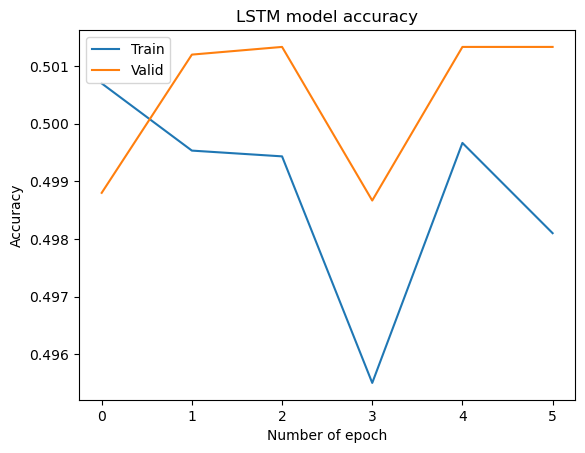

In [37]:
# Plotting graph for model built
    # Accuracy graph
plt.title('LSTM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Number of epoch')
plt.plot(rnn_history.history['acc'], label = 'Train')
plt.plot(rnn_history.history['val_acc'], label = 'Valid')
plt.legend(loc='best')
plt.show()

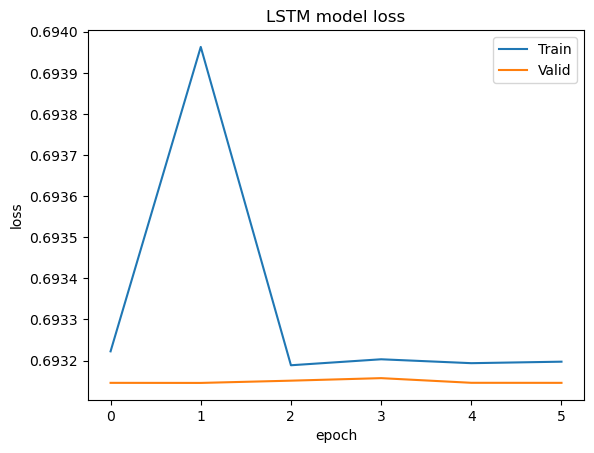

In [38]:
 # Loss graph
plt.title('LSTM model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.plot(rnn_history.history['loss'], label = 'Train')
plt.plot(rnn_history.history['val_loss'], label = 'Valid')
plt.legend(loc='best')
plt.show()

In [39]:
# Final Results
print("\nDeep Neural Network")
print("Traning Accuracy : {}" .format(dnn_history.history['acc']))
print("Validation Accuracy : {}" .format(dnn_history.history['val_acc']))
print("\nTraning Loss : {}" .format(dnn_history.history['loss']))
print("Validation Loss : {}" .format(dnn_history.history['val_loss']))

print("\n\n\nConvolution Neural Network")
print("Traning Accuracy : {}" .format(cnn_history.history['acc']))
print("Validation Accuracy : {}" .format(cnn_history.history['val_acc']))
print("\nTraning Loss : {}" .format(cnn_history.history['loss']))
print("Validation Loss : {}" .format(cnn_history.history['val_loss']))

print("\n\n\nLSTM")
print("Traning Accuracy : {}" .format(rnn_history.history['acc']))
print("Validation Accuracy : {}" .format(rnn_history.history['val_acc']))
print("\nTraning Loss : {}" .format(rnn_history.history['loss']))
print("Validation Loss : {}" .format(rnn_history.history['val_loss']))


Deep Neural Network
Traning Accuracy : [0.49709999561309814, 0.4944666624069214, 0.49639999866485596, 0.4982333481311798, 0.4988333284854889, 0.49906668066978455]
Validation Accuracy : [0.5008000135421753, 0.5008000135421753, 0.49933332204818726, 0.49933332204818726, 0.5008000135421753, 0.49933332204818726]

Traning Loss : [63541.7265625, 64726.47265625, 46250.06640625, 59035.296875, 83116.1328125, 55410.15234375]
Validation Loss : [215326.015625, 252988.375, 252988.375, 252988.375, 252988.375, 252988.375]



Convolution Neural Network
Traning Accuracy : [0.49513334035873413, 0.5005333423614502, 0.49880000948905945, 0.499833345413208, 0.49799999594688416, 0.5009333491325378]
Validation Accuracy : [0.49986666440963745, 0.5013333559036255, 0.49986666440963745, 0.49986666440963745, 0.49986666440963745, 0.5002666711807251]

Traning Loss : [525974.25, 518414.125, 789540.0625, 442649.5, 228485.21875, 331590.5625]
Validation Loss : [395093.03125, 2159410.0, 15983.1455078125, 187100.140625, 2

In [41]:
# Making prediction on any single review using three models that we have built

# Getting input from user
print("\nMAKING PREDICTION ON SINGLE INSTANCE USING THREE MODELS THAT WE HAVE BUILT")
reviewNo = int(input("\nEnter the review number whose sentiment is to be predcited"))
reviewText = X[reviewNo]
print("\nCONTENT OF THE REVIEW CHOSEN IS")
print(reviewText)


MAKING PREDICTION ON SINGLE INSTANCE USING THREE MODELS THAT WE HAVE BUILT



Enter the review number whose sentiment is to be predcited 10



CONTENT OF THE REVIEW CHOSEN IS
Phil the Alien is one of those quirky films where the humour is based around the oddness of everything rather than actual punchlines At first it was very odd and pretty funny but as the movie progressed didn find the jokes or oddness funny anymore Its low budget film thats never problem in itself there were some pretty interesting characters but eventually just lost interest imagine this film would appeal to stoner who is currently partaking For something similar but better try Brother from another planet 


In [42]:
# Converting text to numeric form
    #Using the tokenizer built earlier
#Since we have trained with a list of reviews and now we are feeding in a string, we need to apply "text_to_word_sequence" before tokenizing
reviewText = text_to_word_sequence(reviewText)
reviewProcessed = tokenizer.texts_to_sequences(reviewText)
print("\nINTERGER SEQUENCE OF THE REVIEW CHOSEN IS")
print(reviewProcessed)


INTERGER SEQUENCE OF THE REVIEW CHOSEN IS
[[4481], [1], [1084], [5], [24], [3], [143], [2524], [101], [111], [1], [1148], [5], [436], [183], [1], [], [3], [261], [244], [69], [805], [], [26], [84], [6], [10], [49], [1003], [2], [180], [152], [15], [11], [1], [12], [], [153], [165], [1], [578], [36], [], [152], [1504], [90], [351], [326], [16], [1604], [107], [430], [7], [380], [35], [67], [44], [180], [219], [97], [15], [837], [37], [407], [592], [801], [8], [16], [56], [1319], [4], [], [31], [5], [3504], [], [13], [136], [719], [15], [122], [344], [574], [33], [157], [1245]]


In [43]:
flat_list = []
for sublist in reviewProcessed:
    for item in sublist:
        flat_list.append(item)
#Making the entire items as a single list
flat_list = [flat_list]
#Padding to fit into model
reviewSequence = pad_sequences(flat_list, padding='post', maxlen=maxlen)

In [44]:
#Predicting the sentiment of review using three models
print("\n'0 to 0.5' - Negative ; '0.51 - 1' - Positive")
print("\nPredition by Simple Neural network model is")
print(dnn_model.predict(reviewSequence))
print("\nPredition by Convolution Neural network model is")
print(cnn_model.predict(reviewSequence))
print("\nPredition by LSTM Recurrent Neural network model is")
print(rnn_model.predict(reviewSequence))



'0 to 0.5' - Negative ; '0.51 - 1' - Positive

Predition by Simple Neural network model is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
[[0.5009018]]

Predition by Convolution Neural network model is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
[[0.49968356]]

Predition by LSTM Recurrent Neural network model is
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step
[[0.49724665]]
